# Homework 7 - Part B

*Note that there are two different notebooks for HW assignment 7. This is part A. There will be two different assignments in gradescope for each part. The deadlines are the same for both parts.*

## References

+ Lectures 27-28 (inclusive).


## Instructions

+ Type your name and email in the "Student details" section below.
+ Develop the code and generate the figures you need to solve the problems using this notebook.
+ For the answers that require a mathematical proof or derivation you should type them using latex. If you have never written latex before and you find it exceedingly difficult, we will likely accept handwritten solutions.
+ The total homework points are 100. Please note that the problems are not weighed equally.

In [56]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib_inline
matplotlib_inline.backend_inline.set_matplotlib_formats('svg')
import seaborn as sns
sns.set_context("paper")
sns.set_style("ticks")

import scipy
import scipy.stats as st
import urllib.request
import os

def download(
    url : str,
    local_filename : str = None
):
    """Download a file from a url.
    
    Arguments
    url            -- The url we want to download.
    local_filename -- The filemame to write on. If not
                      specified 
    """
    if local_filename is None:
        local_filename = os.path.basename(url)
    urllib.request.urlretrieve(url, local_filename)

In [57]:
import pyro
import pyro.distributions as dist
from pyro.infer import MCMC, NUTS
import torch

## Problem 1  - Bayesian Linear regression on steroids 

The purpose of this problem is to demonstrate that we have learned enough to do very complicated things.
In the first part, we will do Bayesian linear regression with radial basis functions (RBFs) in which we characterize the posterior of all parameters, including the length-scales of the RBFs.
In the second part, we are going to build a model that has an input-varying noise. Such models are called heteroscedastic models. 

We need to write some `pytorch` code to compute the design matrix. This is absolutely necessary so that `pyro` can differentiate through all expressions.

In [58]:
class RadialBasisFunctions(torch.nn.Module):
    """Radial basis functions basis.
    
    Arguments:
    X   -  The centers of the radial basis functions.
    ell -  The assumed length scale.
    """
    def __init__(self, X, ell):
        super().__init__()
        self.X = X
        self.ell = ell
        self.num_basis = X.shape[0]
    def forward(self, x):
        distances = torch.cdist(x, self.X)
        return torch.exp(-.5 * distances ** 2 / self.ell ** 2)

Here is how you can use them:

In [59]:
# Make the basis
x_centers = torch.linspace(-1, 1, 10).unsqueeze(-1)
ell = 0.2
basis = RadialBasisFunctions(x_centers, ell)

# Some points (need to be N x 1)
x = torch.linspace(-1, 1, 100).unsqueeze(-1)

# Evaluate the basis
Phi = basis(x)

# Here is the shape of Phi
print(Phi.shape)

torch.Size([100, 10])


Here is how they look like:

<>:3: SyntaxWarning: invalid escape sequence '\p'
<>:4: SyntaxWarning: invalid escape sequence '\p'
<>:3: SyntaxWarning: invalid escape sequence '\p'
<>:4: SyntaxWarning: invalid escape sequence '\p'
C:\Users\a0492329\AppData\Local\Temp\ipykernel_63920\2842066789.py:3: SyntaxWarning: invalid escape sequence '\p'
  ax.plot(x, Phi[:, i], label=f"$\phi_{i}$")
C:\Users\a0492329\AppData\Local\Temp\ipykernel_63920\2842066789.py:4: SyntaxWarning: invalid escape sequence '\p'
  ax.set(xlabel="$x$", ylabel="$\phi(x)$")


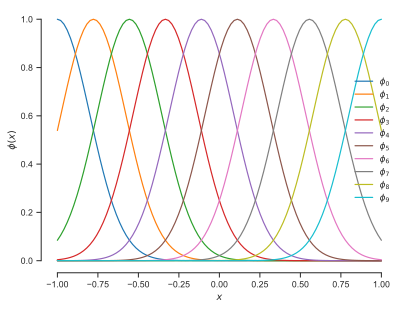

In [60]:
fig, ax = plt.subplots()
for i in range(Phi.shape[1]):
    ax.plot(x, Phi[:, i], label=f"$\phi_{i}$")
ax.set(xlabel="$x$", ylabel="$\phi(x)$")
ax.legend(loc="best", frameon=False)
sns.despine(trim=True);

### Part A - Hierarchical Bayesian linear regression with input-independent noise

We will analyze the motorcycle dataset. The data is loaded below.

In [61]:
url = "https://github.com/PredictiveScienceLab/data-analytics-se/raw/master/lecturebook/data/motor.dat"
download(url)

We will work with the scaled data:

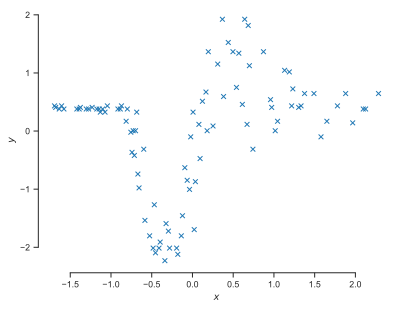

In [62]:
from sklearn.preprocessing import StandardScaler

data = np.loadtxt('motor.dat')
scaler = StandardScaler()
data = scaler.fit_transform(data)
X = torch.tensor(data[:, 0], dtype=torch.float32).unsqueeze(-1)
Y = torch.tensor(data[:, 1], dtype=torch.float32)

fig, ax = plt.subplots()
ax.plot(X, Y, 'x')
ax.set(xlabel="$x$", ylabel="$y$")
sns.despine(trim=True);

### Part A.I

Your goal is to implement the model described below.
We use the radial basis functions (`RadialBasisFunction`) with centers, $x_i$ at $m=50$ equidistant points between the minimum and maximum of the observed inputs:

$$
\phi_i(x;\ell) = \exp \left( - \frac{(x - x_i)^2}{2 \ell^2} \right),
$$

for $i=1,\dots,m$.
We denote the vector of RBFs evaluated at $x$ as $\boldsymbol{\phi}(x;\ell)$.

We are not going to pick the length-scales $\ell$ by hand. Instead, we will put a prior on it:

$$
\ell \sim \text{Exponential}(1).
$$

The corresponding weights have priors:

$$
w_j | \alpha_i \sim N(0, \alpha_j^2),
$$

and its $\alpha_j$ has a prior:

$$
\alpha_j \sim \text{Exponential}(1),
$$

for $j=1,\dots,m$.

Denote our data as:

$$
x_{1:n} = (x_1, \dots, x_n)^T,\;\text{(inputs)},
$$

and

$$
y_{1:n} = (y_1, \dots, y_n)^T,\;\text{(outputs)}.
$$

The likelihood of the data is:

$$
y_i | \mathbf{w}, \sigma \sim N(\mathbf{w}^T \boldsymbol{\phi}(x_i;\ell), \sigma^2),
$$

for $i=1,\dots,n$.

$$
y_n | \ell, \mathbf{w}, \sigma \sim N(\mathbf{w}^T \boldsymbol{\phi}(x_n;\ell), \sigma^2).
$$

Complete the `pyro` implementation of that model:

**Answer:**

In [63]:
def model(X, y, num_centers=50):
    with pyro.plate("centers", num_centers):
        alpha = pyro.sample("alpha", dist.Exponential(1.0))
        # Notice below that dist.Normal needs the standard deviation - not the variance
        # We follow a different convention in the lecture notes
        w = pyro.sample("w", dist.Normal(0.0, alpha))
    ell = pyro.sample("ell", dist.Exponential(1.0))# Complete the code assign to ell the correct prior distribution (an Exponential(1)).
    # Hint: Look at alpha.
    sigma = pyro.sample("sigma", dist.Exponential(1.0))# Complete the code assign to sigma the correct prior distribution (an Exponential(1))
    x_centers = torch.linspace(X.min(), X.max(), num_centers).unsqueeze(-1)
    Phi = RadialBasisFunctions(x_centers, ell)(X)
    with pyro.plate("data", X.shape[0]):
        pyro.sample("y", dist.Normal(Phi @ w, sigma), obs=y)
    # Notice that I'm making the model return all the variables that I have made.
    # This is not essential for characterizing the posterior, but it does reduce redundant code
    # when we are trying to get the posterior predictive.
    return locals()

The graph will help to understand the model:

In [64]:
#pyro.render_model(model, (X, Y), render_distributions=True)

Use `pyro.infer.autoguide.AutoDiagonalNormal` to make the guide:

In [65]:
guide = pyro.infer.autoguide.AutoDiagonalNormal(model)

We will use variational inference. Here is the training code from the hans-on activity:

In [66]:
def train(model, guide, data, num_iter=5_000):
    """Train a model with a guide.

    Arguments
    ---------
    model    -- The model to train.
    guide    -- The guide to train.
    data     -- The data to train the model with.
    num_iter -- The number of iterations to train.
    
    Returns
    -------
    elbos -- The ELBOs for each iteration.
    param_store -- The parameters of the model.
    """

    pyro.clear_param_store()

    optimizer = pyro.optim.Adam({"lr": 0.001})

    svi = pyro.infer.SVI(
        model,
        guide,
        optimizer,
        loss=pyro.infer.JitTrace_ELBO()
    )

    elbos = []
    for i in range(num_iter):
        loss = svi.step(*data)
        elbos.append(-loss)
        if i % 1_000 == 0:
            print(f"Iteration: {i} Loss: {loss}")

    return elbos, pyro.get_param_store()

### Part A.II

Train the model for 20,000 iterations. Call the `train()` function we defined above to do it.
Make sure you store the returned elbo values because you will need them later.

**Answer:**

In [67]:
elbos,params = train(model,guide,(X,Y), num_iter=20000)

Iteration: 0 Loss: 830.6221313476562
Iteration: 1000 Loss: 231.7598419189453
Iteration: 2000 Loss: 169.9781951904297
Iteration: 3000 Loss: 133.08607482910156
Iteration: 4000 Loss: 146.67816162109375
Iteration: 5000 Loss: 123.67375946044922
Iteration: 6000 Loss: 130.07366943359375
Iteration: 7000 Loss: 136.4361114501953
Iteration: 8000 Loss: 140.70323181152344
Iteration: 9000 Loss: 134.4396209716797
Iteration: 10000 Loss: 129.58590698242188
Iteration: 11000 Loss: 128.73870849609375
Iteration: 12000 Loss: 121.89901733398438
Iteration: 13000 Loss: 150.6586456298828
Iteration: 14000 Loss: 145.8036346435547
Iteration: 15000 Loss: 128.98193359375
Iteration: 16000 Loss: 129.93650817871094
Iteration: 17000 Loss: 132.521240234375
Iteration: 18000 Loss: 123.24565887451172
Iteration: 19000 Loss: 133.42276000976562


### Part A.III

Plot the evolution of the ELBO.

**Answer:**

Text(0, 0.5, 'ELBO')

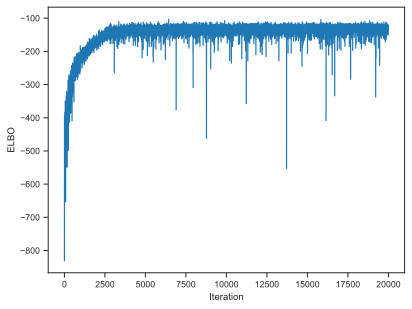

In [68]:
num_iterations = 20000
fig, ax = plt.subplots()
ax.plot(torch.arange(num_iterations),elbos)
ax.set_xlabel("Iteration")
ax.set_ylabel("ELBO")


### Part A.IV

Take 1,000 posterior samples.

**Answer:**

I'm giving you this one because it is a bit tricky. You need to use the `pyro.infer.Predictive` class to do it. Here is how you can use it:

In [69]:
post_samples = pyro.infer.Predictive(model, guide=guide, num_samples=1000)(X, Y)
# Just modify the call to get the right number of samples

### Part A.V

Plot the histograms of the posteriors of $\ell$, $\sigma$, $\alpha_{10}$ and $w_{10}$.

**Answer:**

<>:14: SyntaxWarning: invalid escape sequence '\e'
<>:22: SyntaxWarning: invalid escape sequence '\s'
<>:14: SyntaxWarning: invalid escape sequence '\e'
<>:22: SyntaxWarning: invalid escape sequence '\s'
C:\Users\a0492329\AppData\Local\Temp\ipykernel_63920\3481112175.py:14: SyntaxWarning: invalid escape sequence '\e'
  ax.set(xlabel="$\ell$", ylabel="Frequency")
C:\Users\a0492329\AppData\Local\Temp\ipykernel_63920\3481112175.py:22: SyntaxWarning: invalid escape sequence '\s'
  ax.set(xlabel="$\sigma$", ylabel="Frequency")


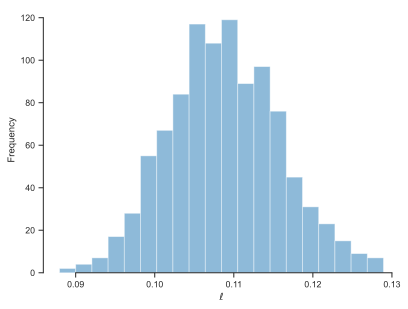

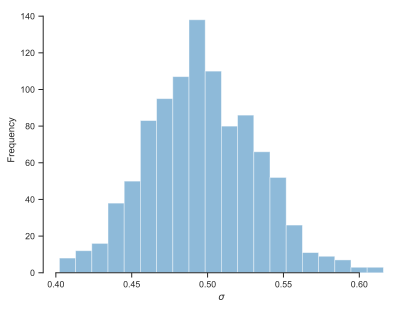

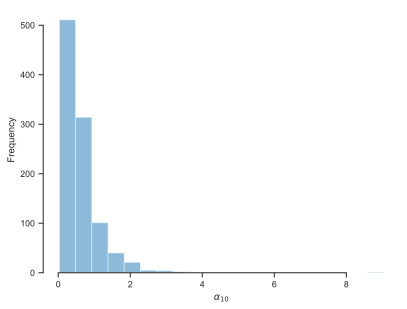

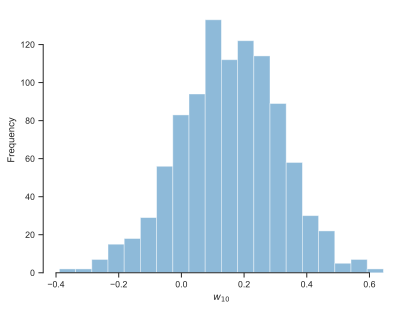

In [70]:
# First, here is how to extract the samples.
ell = post_samples["ell"]
# You can do `post_samples.keys()` to see all the keys.
# But they should correspond to the names of the latent variables in the model.
sigma = post_samples["sigma"]
alphas = post_samples["alpha"]
ws = post_samples["w"][:,10]

# Here is the code to make the histogram for the length scale.
fig, ax = plt.subplots()
# **VERY IMPORTANT** - You need to detach the tensor from the computational graph.
# Otherwise, you will get very very strange behavior.
ax.hist(ell.detach().numpy(), bins=20, alpha=.5)
ax.set(xlabel="$\ell$", ylabel="Frequency")
sns.despine(trim=True);

# Your code for the other histograms here
fig, ax = plt.subplots()
# **VERY IMPORTANT** - You need to detach the tensor from the computational graph.
# Otherwise, you will get very very strange behavior.
ax.hist(sigma.detach().numpy(), bins=20, alpha=.5)
ax.set(xlabel="$\sigma$", ylabel="Frequency")
sns.despine(trim=True);

fig, ax = plt.subplots()
# **VERY IMPORTANT** - You need to detach the tensor from the computational graph.
# Otherwise, you will get very very strange behavior.
ax.hist(alphas[:,10].detach().numpy(), bins=20, alpha=.5)
ax.set(xlabel="$\\alpha_{10}$", ylabel="Frequency")
sns.despine(trim=True);

fig, ax = plt.subplots()
# **VERY IMPORTANT** - You need to detach the tensor from the computational graph.
# Otherwise, you will get very very strange behavior.
ax.hist(ws.detach().numpy(), bins=20, alpha=.5)
ax.set(xlabel="$w_{10}$", ylabel="Frequency")
sns.despine(trim=True);

### Part A.VI

Let's extend them model to make predictions.

**Answer:**

In [71]:
# Again, I'm giving you most of the code here.

def predictive_model(X, y, num_centers=50):
    # First we run the original model get all the variables
    params = model(X, y, num_centers)
    # Here is how you can access the variables
    w = params["w"]
    ell = params["ell"]# Access the length scale
    sigma = params["sigma"]# Access the standard deviation of the measurement noise
    x_centers = params["x_centers"]# Access the centers of the radial basis functions
    # Here are the points where we want to make predictions
    xs = torch.linspace(X.min(), X.max(), 100).unsqueeze(-1)
    # Evaluate the basis on the prediction points
    Phi = RadialBasisFunctions(x_centers, ell)(xs)
    # Make the predictions - we use a deterministic node here because we want to
    # save the results of the predictions.
    predictions = pyro.deterministic("predictions", Phi @ w)
    # Finally, we add the measurement noise
    predictions_with_noise = pyro.sample("predictions_with_noise", dist.Normal(predictions, sigma))
    return locals()

### Part A.VII

Extract the posterior predictive distribution using 10,000 samples. Separate aleatory and epistemic uncertainty.

**Answer:**

In [72]:
# Here is how to make the predictions. Just change the number of samples to the right number.
post_pred = pyro.infer.Predictive(predictive_model, guide=guide, num_samples=10)(X, Y)
# We will predict here:
xs = torch.linspace(X.min(), X.max(), 100).unsqueeze(-1)

# You can extract the predictions from post_pred like this:
predictions = post_pred["predictions"]
# Note that we extracted the deterministic node called "predictions" from the model.
# Get the epistemic uncertainty in the usual way:
p_500, p_025, p_975 = np.percentile(predictions, [50, 2.5, 97.5], axis=0)
# Extract predictions with noise
predictions_with_noise = post_pred["predictions_with_noise"]
# Get the aleatory uncertainty
ap_025, ap_975 = np.percentile(predictions_with_noise, [2.5,97.5], axis = 0)


### Part A.VIII

Plot the data, the median, the 95% credible interval of epistemic uncertainty and the 95% credible interval of aleatory uncertainty, along with five samples from the posterior.

**Answer:**

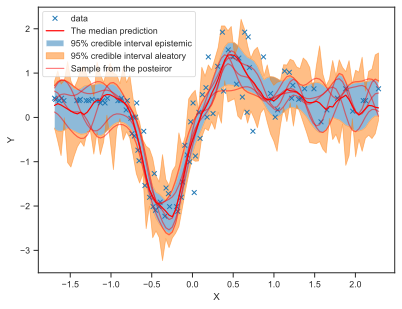

In [98]:
fig, ax = plt.subplots()
ax.plot(X,Y,"x",label = "data")
ax.plot(xs,p_500.flatten(),'r', label = "The median prediction")
ax.fill_between(xs.squeeze(),p_025.flatten(),p_975.flatten(), alpha = .5, label = "95% credible interval epistemic")
ax.fill_between(xs.squeeze(),ap_025.flatten(),p_025.flatten(), alpha = .5, label = "95% credible interval aleatory",color = sns.color_palette()[1])
ax.fill_between(xs.squeeze(),p_975.flatten(),ap_975.flatten(), alpha = .5, color = sns.color_palette()[1])

for i in range(5):
    ax.plot(xs,predictions[i,0,:],'r',alpha=.5,label="Sample from the posteiror" if i == 0 else None)
ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.legend(loc="best")

### Part B - Heteroscedastic regression

We are going to build a model that has an input-varying noise. Such models are called heteroscedastic models.
Here I will let you do more of the work.

Everything is as before for $\ell$, the $\alpha_j$'s, and the $w_j$'s.
We now introduce a model for the noise that is input dependent.
It will use the same RBFs as the mean function.
But let's use a different length-scale, $\ell_\sigma$.
So, we add:

$$
\ell_\sigma \sim \text{Exponential}(1),
$$

$$
\alpha_{\sigma,j} \sim \text{Exponential}(1),
$$

and

$$
w_{\sigma,j} | \alpha_{\sigma,j} \sim N(0, \alpha_{\sigma,j}^2),
$$

for $j=1,\dots,m$.

Our model for the input-dependent noise variance is:

$$
\sigma(x;\mathbf{w}_\sigma,\ell) = \exp\left(\mathbf{w}_\sigma^T \boldsymbol{\phi}(x;\ell_\sigma)\right).
$$

So, the likelihood of the data is:

$$
y_i | \mathbf{w}, \mathbf{w}_\sigma \sim N\left(\mathbf{w}^T \boldsymbol{\phi}(x_i;\ell), \sigma^2(x_i;\mathbf{w}_\sigma,\ell)\right),
$$

You will implement this model.

### Part B.I

Complete the code below:

In [101]:
def model(X, y, num_centers=50):
    with pyro.plate("centers", num_centers):
        alpha = pyro.sample("alpha", dist.Exponential(1.0))
        w = pyro.sample("w", dist.Normal(0.0, alpha))
        # Let's add the generalized linear model for the log noise.
        alpha_noise = pyro.sample("alpha_noise", dist.Exponential(1.0))
        w_noise = pyro.sample("w_noise", dist.Normal(0.0, alpha_noise))
    ell = pyro.sample("ell", dist.Exponential(1.))
    ell_noise = pyro.sample("ell_noise", dist.Exponential(1.0))
    x_centers = torch.linspace(X.min(), X.max(), num_centers).unsqueeze(-1)
    Phi = RadialBasisFunctions(x_centers, ell)(X)
    Phi_noise = RadialBasisFunctions(x_centers, ell_noise)(X)
    # This is the new part 2/2
    model_mean = Phi @ w
    sigma = torch.exp(Phi_noise @ w_noise)
    with pyro.plate("data", X.shape[0]):
        pyro.sample("y", dist.Normal(model_mean, sigma), obs=y)
    return locals()

Make a `pyro.infer.autoguide.AutoDiagonalNormal` guide:

In [102]:
guide = pyro.infer.autoguide.AutoDiagonalNormal(model)

Make the graph of the model using `pyro` functionality:

In [103]:
#pyro.render_model(model, (X, Y), render_distributions=True)

### Part B.II

Train the model using 20,000 iterations. Then plot the evolution of the ELBO.

**Answer:**

In [104]:
elbos,params = train(model,guide,(X,Y), num_iter=20000)

Iteration: 0 Loss: 642.3901977539062
Iteration: 1000 Loss: 289.45672607421875
Iteration: 2000 Loss: 231.01113891601562
Iteration: 3000 Loss: 182.33798217773438
Iteration: 4000 Loss: 188.8242950439453
Iteration: 5000 Loss: 179.2458953857422
Iteration: 6000 Loss: 163.88816833496094
Iteration: 7000 Loss: 179.88735961914062
Iteration: 8000 Loss: 163.59043884277344
Iteration: 9000 Loss: 176.23345947265625
Iteration: 10000 Loss: 180.9759063720703
Iteration: 11000 Loss: 168.03860473632812
Iteration: 12000 Loss: 154.46237182617188
Iteration: 13000 Loss: 181.8983154296875
Iteration: 14000 Loss: 165.2867889404297
Iteration: 15000 Loss: 177.21067810058594
Iteration: 16000 Loss: 159.7982940673828
Iteration: 17000 Loss: 170.29928588867188
Iteration: 18000 Loss: 162.81265258789062
Iteration: 19000 Loss: 173.70980834960938


### Part B.III

Extend the model to make predictions.

**Answer:**

In [105]:
def predictive_model(X, y, num_centers=50):
    params = model(X, y, num_centers)
    w = params["w"]
    w_noise = params["w_noise"]
    ell = params["ell"]
    ell_noise = params["ell_noise"]
    sigma = params["sigma"]
    x_centers = params["x_centers"]
    xs = torch.linspace(X.min(), X.max(), 100).unsqueeze(-1)
    Phi = RadialBasisFunctions(x_centers,ell)(xs)
    Phi_noise = RadialBasisFunctions(x_centers,ell_noise)(xs)
    predictions = pyro.deterministic("predictions", Phi @ w)
    sigma = pyro.deterministic("sigma", torch.exp(Phi_noise @ w_noise))
    predictions_with_noise = pyro.sample("predictions_with_noise",dist.Normal(predictions,sigma))
    return locals()

### Part B.IV

Now, make predictions and calculate the epistemic and aleatory uncertainties as in part A.VII.

**Answer:**

In [106]:
# Here is how to make the predictions. Just change the number of samples to the right number.
post_pred = pyro.infer.Predictive(predictive_model, guide=guide, num_samples=10)(X, Y)
# We will predict here:
xs = torch.linspace(X.min(), X.max(), 100).unsqueeze(-1)

# You can extract the predictions from post_pred like this:
predictions = post_pred["predictions"]
# Note that we extracted the deterministic node called "predictions" from the model.
# Get the epistemic uncertainty in the usual way:
p_500, p_025, p_975 = np.percentile(predictions, [50, 2.5, 97.5], axis=0)
# Extract predictions with noise
predictions_with_noise = post_pred["predictions_with_noise"]
# Get the aleatory uncertainty
ap_025, ap_975 = np.percentile(predictions_with_noise, [2.5,97.5], axis = 0)

### Part B.V

Make the same plot as in part A.VIII.

**Answer:**

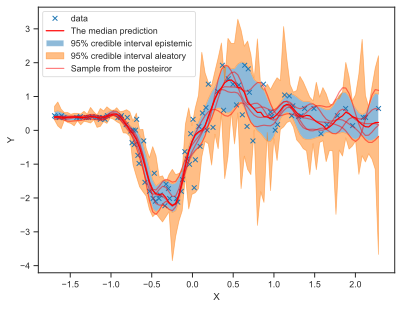

In [107]:
fig, ax = plt.subplots()
ax.plot(X,Y,"x",label = "data")
ax.plot(xs,p_500.flatten(),'r', label = "The median prediction")
ax.fill_between(xs.squeeze(),p_025.flatten(),p_975.flatten(), alpha = .5, label = "95% credible interval epistemic")
ax.fill_between(xs.squeeze(),ap_025.flatten(),p_025.flatten(), alpha = .5, label = "95% credible interval aleatory",color = sns.color_palette()[1])
ax.fill_between(xs.squeeze(),p_975.flatten(),ap_975.flatten(), alpha = .5, color = sns.color_palette()[1])

for i in range(5):
    ax.plot(xs,predictions[i,0,:],'r',alpha=.5,label="Sample from the posteiror" if i == 0 else None)
ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.legend(loc="best")

### Part B.VI

Plot the estimated noise standard deviation as a function of of the input along with a 95% credible interval.

**Answer:**

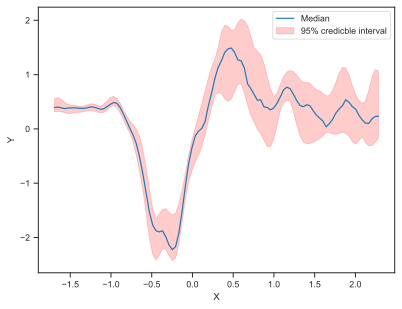

In [110]:
sigma = post_pred["sigma"]
p_500, p_025, p_975 = np.percentile(predictions, [50, 2.5, 97.5], axis=0)

fig, ax = plt.subplots()
ax.plot(xs,p_500.flatten(), label = "Median")
ax.fill_between(xs.squeeze(), p_025.flatten(), p_975.flatten(), color = 'r', alpha = .2, label = "95% credicble interval")
ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.legend(loc = "best")

### Part B.VII

Which model do you prefer? Why?

**Answer:**
<br><br><br><br><br><br><br><br><br><br><br><br><br><br>

### Part B.IX

Can you think of any way to improve the model?
Go crazy! This is the last homework assignment!
There is no right or wrong answer here.
But if you have a good idea, we will give you extra credit.

In [111]:
## Your code and answers here